# Bibliotheken importeren

In [2]:
import pandas as pd 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt

# !!! SKLEARN IS DEPRECATED, PIP INSTALL "scikit-learn" INSTEAD !!!
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

# Data inlezen en kolommen selecteren

In [3]:
# !!! HOEFT DIT ALLEEN TE RUNNEN WANNEER DE DATA NOG NIET IN DE SQLITE DATABASE STAAT !!!
def data_to_sqlite():
    DB = {'servername': r'LAPTOP-NBUM6TMN',
        'database': 'johari'}

    ssms_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                        ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')
    ssms_cursor = ssms_conn.cursor()

    # Data inlezen van de benodigde tabellen
    returned_item = pd.read_sql("SELECT * FROM RETURNED_ITEM", ssms_conn)
    order_details = pd.read_sql("SELECT * FROM ORDERS", ssms_conn)

    # Naar SQLite database
    sqlite_conn = sqlite3.connect('../data/johari.db')
    returned_item.to_sql('RETURNED_ITEM', con=sqlite_conn, if_exists='replace', index=False)
    order_details.to_sql('ORDER_DETAILS', con=sqlite_conn, if_exists='replace', index=False)

In [4]:
# Lees de data in van de SQLite database
sqlite_conn = sqlite3.connect('../data/johari.db')
returned_item = pd.read_sql("SELECT * FROM RETURNED_ITEM", sqlite_conn)
order_details = pd.read_sql("SELECT * FROM ORDER_DETAILS", sqlite_conn)

# Merge de twee tabellen. "how" is de manier van mergen, "left" betekent dat alle rijen van de linker tabel wordt behouden (we willen alle order details behouden, ook al zijn ze niet geretourneerd)
df = pd.merge(order_details, returned_item, how='left', left_on='ORDER_DETAILS_id', right_on='RETURNED_ORDER_DETAIL_id')
df.to_sql('MERGED', con=sqlite_conn, if_exists='replace', index=False)

# Alleen de kolommen selecteren die nodig zijn voor de trainset en testset
df = df.loc[:, ['ORDER_PRODUCT_id', 'ORDER_quantity', 'ORDER_unit_sale', 'ORDER_total_sale_amount', 'RETURNED_quantity', 'RETURNED_REASON_description']]

# Als de RETURNED_quantity NaN is, vervang deze dan met 0
df['RETURNED_quantity'] = df['RETURNED_quantity'].fillna(0)

# Als de RETURNED_REASON_description NaN is, vervang deze dan met "No return"
df['RETURNED_REASON_description'] = df['RETURNED_REASON_description'].fillna('No return')

df

,ORDER_PRODUCT_id,ORDER_quantity,ORDER_unit_sale,ORDER_total_sale_amount,RETURNED_quantity,RETURNED_REASON_description
0,1,84,6.59,0.00,0.0,No return
1,1,126,6.59,0.00,0.0,No return
2,1,122,6.03,68.32,0.0,No return
3,1,122,6.59,0.00,0.0,No return
4,1,272,5.26,361.76,0.0,No return
...,...,...,...,...,...,...
43058,112,70,9.00,0.00,0.0,No return
43059,113,44,9.00,132.00,0.0,No return
43060,114,8,140.00,480.00,0.0,No return
43061,115,24,10.00,0.00,0.0,No return


# One-hot encoding van onafhankelijke niet-numerieke variabelen

In [4]:
"""
dummies_dataframe = pd.get_dummies(df.loc[:, ['RETURNED_REASON_description']]) # One-hot encoding
dummies_dataframe.columns = dummies_dataframe.columns.str.replace('RETURNED_REASON_description_', '') # Kolomnamen aanpassen
dummies_dataframe.head()
"""

,Defective product,Incomplete product,Unsatisfactory product,Wrong product ordered,Wrong product shipped
0,False,False,True,False,False
1,False,True,False,False,False
2,False,False,False,False,True
3,False,False,False,True,False
4,True,False,False,False,False


In [5]:
"""
df = pd.concat([df, dummies_dataframe], axis=1) # Dataframes samenvoegen
df = df.drop(columns=['RETURNED_REASON_description']) # Vervangende kolom verwijderen
df = df.loc[:, ['RETURNED_PRODUCT_TYPE_id', 'Defective product', 'Incomplete product', 'Unsatisfactory product', 'Wrong product ordered', 'Wrong product shipped', 'RETURNED_quantity']] # Kolomvolgorde aanpassen
df.head()
"""

,RETURNED_PRODUCT_TYPE_id,Defective product,Incomplete product,Unsatisfactory product,Wrong product ordered,Wrong product shipped,RETURNED_quantity
0,1,False,False,True,False,False,8
1,1,False,True,False,False,False,2
2,1,False,False,False,False,True,22
3,1,False,False,False,True,False,20
4,3,True,False,False,False,False,2


# Verticaal en horizontaal snijden

In [5]:
X = df.drop('RETURNED_REASON_description', axis=1) # Onafhankelijke variabelen
y = df.loc[:, ['RETURNED_REASON_description']] # Afhankelijke variabele
X.head()

,ORDER_PRODUCT_id,ORDER_quantity,ORDER_unit_sale,ORDER_total_sale_amount,RETURNED_quantity
0,1,84,6.59,0.00,0.0
1,1,126,6.59,0.00,0.0
2,1,122,6.03,68.32,0.0
3,1,122,6.59,0.00,0.0
4,1,272,5.26,361.76,0.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
) # Data splitsen in trainings- en testset

In [31]:
list(X.columns)

['ORDER_PRODUCT_id',
 'ORDER_quantity',
 'ORDER_unit_sale',
 'ORDER_total_sale_amount',
 'RETURNED_quantity']

# Decision Tree bouwen en evalueren

# Max_depth = 3

# Geen Max_depth

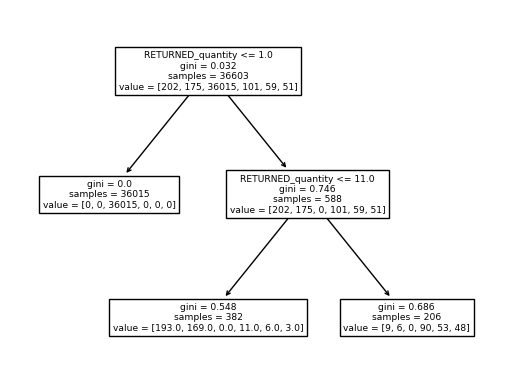

In [15]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(X_train, y_train) # Model trainen
tree.plot_tree(dtree, feature_names=X.columns) # Boomstructuur weergeven
plt.show()

In [16]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns={0: 'Predicted_Return_Reason'})
model_results_frame = pd.concat([y_test.reset_index()['RETURNED_REASON_description'], predicted_df], axis=1)
model_results_frame

,RETURNED_REASON_description,Predicted_Return_Reason
0,No return,No return
1,No return,No return
2,No return,No return
3,No return,No return
4,No return,No return
...,...,...
6455,Unsatisfactory product,Unsatisfactory product
6456,No return,No return
6457,No return,No return
6458,No return,No return


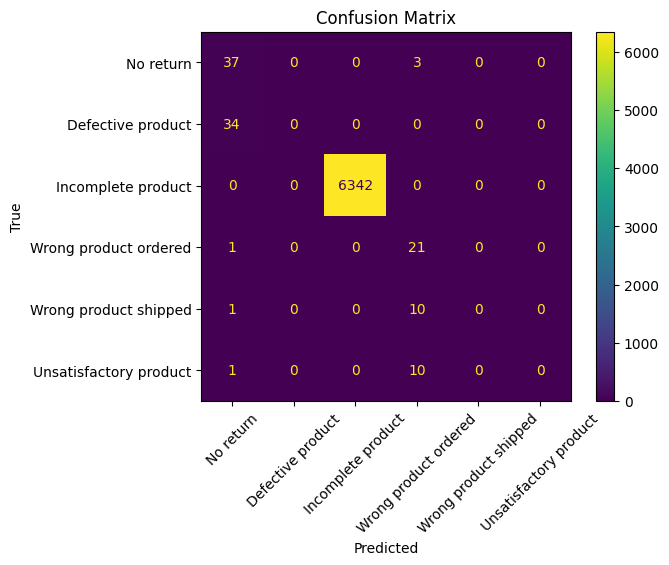

In [20]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = ['No return', 'Defective product', 'Incomplete product', 'Wrong product ordered', 'Wrong product shipped', 'Unsatisfactory product'])

cm_display.plot()
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
metrics.accuracy_score(model_results_frame['RETURNED_REASON_description'], model_results_frame['Predicted_Return_Reason']) # Accuracy score berekenen, hoeveel procent van de voorspellingen is correct. 1 is 100% correct, 0 is 0% correct

0.9907120743034056